Mounted at /content/drive
Mounted Google Drive at /content/drive
Using device: cpu
Using 100 matches
Train: 80, Val: 10, Test: 10


Indexing train matches:   0%|          | 0/80 [00:00<?, ?it/s]

Indexing val matches:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing test matches:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/3 - Training:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 1.3578, Train Acc: 0.2351, Val Event Acc: 0.2556


Epoch 2/3 - Training:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.7888, Train Acc: 0.4527, Val Event Acc: 0.2296


Epoch 3/3 - Training:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.4627, Train Acc: 0.6222, Val Event Acc: 0.2275


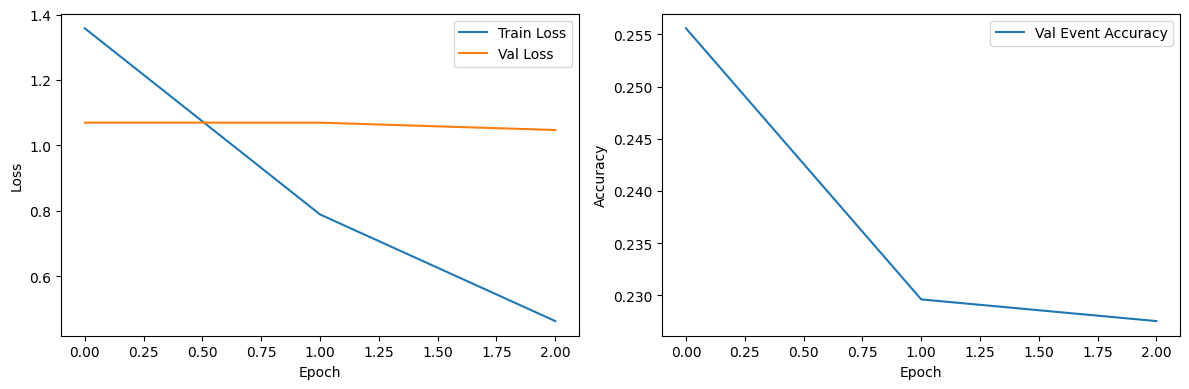

Evaluating:   0%|          | 0/62 [00:00<?, ?it/s]

Overall Results:
                    precision    recall  f1-score   support

  Ball out of play       0.22      0.44      0.29       835
          Throw-in       0.10      0.17      0.13       369
              Foul       0.09      0.06      0.07       307
Indirect free-kick       0.00      0.00      0.00       122
         Clearance       0.06      0.02      0.03        84
              Goal       0.00      0.00      0.00        36
            Corner       0.02      0.01      0.01        91
      Substitution       0.00      0.00      0.00         7
          Kick-off       0.00      0.00      0.00         9
       Yellow card       0.00      0.00      0.00        12
           Offside       0.00      0.00      0.00        54
  Direct free-kick       0.00      0.00      0.00        31
        Background       0.53      0.34      0.41      1957

          accuracy                           0.28      3914
         macro avg       0.08      0.08      0.07      3914
      weighted avg   

In [11]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive
import gc
import shutil

# Mount Google Drive with error handling
def mount_google_drive(mountpoint='/content/drive'):
    if os.path.ismount(mountpoint):
        print(f"Google Drive already mounted at {mountpoint}")
        return
    try:
        #Clear mountpoint if it exists and contains files (uncomment if needed)
        if os.path.exists(mountpoint) and os.listdir(mountpoint):
            shutil.rmtree(mountpoint)
        os.makedirs(mountpoint, exist_ok=True)
        drive.mount(mountpoint, force_remount=True)
        print(f"Mounted Google Drive at {mountpoint}")
    except ValueError as e:
        print(f"Error mounting Google Drive: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error during mounting: {e}")
        raise

mount_google_drive()

# Path to your SoccerNet dataset shortcut
SOCCERNET_PATH = "/content/drive/MyDrive/soccernet"

# Define constants
FPS = 2
WINDOW_SIZE = 32
STEP_SIZE = 4
EVENT_WINDOW = 4

class EventMapper:
    def __init__(self):
        self.events = [
            "Ball out of play", "Throw-in", "Foul", "Indirect free-kick",
            "Clearance", "Shot", "Shot on target", "Goal", "Corner", "Substitution",
            "Kick-off", "Yellow card", "Offside", "Direct free-kick", "Red card",
            "Yellow->red card", "Penalty", "Background"
        ]
        self.event_to_idx = {event: i for i, event in enumerate(self.events)}
        self.idx_to_event = {i: event for i, event in enumerate(self.events)}

    def get_num_classes(self):
        return len(self.events)

    def event_to_index(self, event):
        return self.event_to_idx.get(event, self.event_to_idx["Background"])

    def index_to_event(self, idx):
        return self.idx_to_event[idx]

def game_time_to_frame(game_time, fps=FPS):
    try:
        half, time_str = game_time.split(" - ")
        minutes, seconds = time_str.split(":")
        total_seconds = int(half) * 45 * 60 + int(minutes) * 60 + int(seconds)
        return total_seconds * fps
    except Exception as e:
        print(f"Error parsing game time {game_time}: {e}")
        return 0

def load_labels(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        annotations = data.get('annotations', [])
        frame_labels = []
        for annotation in annotations:
            game_time = annotation['gameTime']
            label = annotation['label']
            visibility = annotation['visibility']
            if visibility == "visible":
                frame_labels.append({
                    'frame': game_time_to_frame(game_time),
                    'label': label
                })
        return frame_labels
    except Exception as e:
        print(f"Error loading labels from {json_path}: {e}")
        return []

def get_match_paths():
    match_paths = []
    leagues = ['england_epl', 'europe_uefa-champions-league', 'france_ligue-1',
               'germany_bundesliga', 'italy_serie-a', 'spain_laliga']
    seasons = ['2014-2015', '2015-2016', '2016-2017']
    for league in leagues:
        league_path = os.path.join(SOCCERNET_PATH, league)
        if not os.path.exists(league_path):
            continue
        for season in seasons:
            season_path = os.path.join(league_path, season)
            if not os.path.exists(season_path):
                continue
            for match_dir in os.listdir(season_path):
                match_path = os.path.join(season_path, match_dir)
                if os.path.isdir(match_path):
                    labels_path = os.path.join(match_path, 'Labels-v2.json')
                    half1_path = os.path.join(match_path, '1_ResNET_TF2.npy')
                    half2_path = os.path.join(match_path, '2_ResNET_TF2.npy')
                    if os.path.exists(labels_path) and os.path.exists(half1_path) and os.path.exists(half2_path):
                        match_paths.append(match_path)
    return match_paths[:100]  # Limit to 100 matches

class SoccerNetDataset(Dataset):
    def __init__(self, match_paths, event_mapper, mode='train', feature_dim=2048):
        self.match_paths = match_paths
        self.event_mapper = event_mapper
        self.mode = mode
        self.feature_dim = feature_dim
        self.samples = []
        self.event_samples = {i: [] for i in range(event_mapper.get_num_classes())}
        self.feature_cache = {}
        self._precompute_indices()
        if mode == 'train':
            self._balance_dataset()
        else:
            self._limit_background_samples()

    def _precompute_indices(self):
        for match_path in tqdm(self.match_paths, desc=f"Indexing {self.mode} matches"):
            try:
                labels_path = os.path.join(match_path, 'Labels-v2.json')
                frame_labels = load_labels(labels_path)
                frame_to_label = {}
                for event in frame_labels:
                    frame = event['frame']
                    label = event['label']
                    for offset in range(-EVENT_WINDOW, EVENT_WINDOW + 1):
                        target_frame = frame + offset
                        if target_frame >= 0:
                            frame_to_label[target_frame] = label
                for half_idx in [1, 2]:
                    half_file = os.path.join(match_path, f'{half_idx}_ResNET_TF2.npy')
                    if not os.path.exists(half_file):
                        continue
                    with open(half_file, 'rb') as f:
                        version = np.lib.format.read_magic(f)
                        shape, _, _ = np.lib.format.read_array_header_1_0(f)
                        num_frames = shape[0]
                    for i in range(0, num_frames - WINDOW_SIZE + 1, STEP_SIZE):
                        middle_frame = i + WINDOW_SIZE // 2
                        global_middle_frame = middle_frame + (45 * 60 * FPS if half_idx == 2 else 0)
                        label = frame_to_label.get(global_middle_frame, "Background")
                        label_idx = self.event_mapper.event_to_index(label)
                        if label == "Background" and self.mode == 'train' and np.random.random() > 0.05:
                            continue
                        sample_info = (match_path, half_idx, i, middle_frame, label_idx)
                        self.samples.append(sample_info)
                        self.event_samples[label_idx].append(sample_info)
            except Exception as e:
                print(f"Error processing {match_path}: {e}")

    def _balance_dataset(self):
        class_counts = {i: len(samples) for i, samples in self.event_samples.items()}
        background_idx = self.event_mapper.event_to_index("Background")
        event_counts = {cls: count for cls, count in class_counts.items() if cls != background_idx}
        if not event_counts:
            return
        target_count = max(100, max(event_counts.values()) * 2)
        background_limit = target_count
        balanced_samples = []
        for cls, samples in self.event_samples.items():
            if len(samples) == 0:
                continue
            if cls == background_idx:
                if len(samples) > background_limit:
                    sampled_indices = np.random.choice(len(samples), background_limit, replace=False)
                    balanced_samples.extend([samples[i] for i in sampled_indices])
                else:
                    balanced_samples.extend(samples)
            else:
                target = min(len(samples) * 4, target_count)
                sampled_indices = np.random.choice(len(samples), target, replace=len(samples) < target)
                balanced_samples.extend([samples[i] for i in sampled_indices])
        self.samples = balanced_samples

    def _limit_background_samples(self):
        background_idx = self.event_mapper.event_to_index("Background")
        background_samples = self.event_samples[background_idx]
        total_event_samples = sum(len(samples) for cls, samples in self.event_samples.items() if cls != background_idx)
        background_limit = total_event_samples
        if len(background_samples) > background_limit:
            sampled_indices = np.random.choice(len(background_samples), background_limit, replace=False)
            sampled_background = [background_samples[i] for i in sampled_indices]
            new_samples = [s for s in self.samples if s[4] != background_idx]
            new_samples.extend(sampled_background)
            self.samples = new_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        match_path, half_idx, window_start, middle_frame, label = self.samples[idx]
        try:
            cache_key = (match_path, half_idx)
            if cache_key in self.feature_cache:
                features = self.feature_cache[cache_key]
            else:
                half_file = os.path.join(match_path, f'{half_idx}_ResNET_TF2.npy')
                features = np.load(half_file)
                if self.mode != 'train':
                    self.feature_cache[cache_key] = features
            if window_start + WINDOW_SIZE > len(features):
                available_frames = len(features) - window_start
                window_features = np.zeros((WINDOW_SIZE, self.feature_dim))
                window_features[:available_frames] = features[window_start:window_start+available_frames]
            else:
                window_features = features[window_start:window_start+WINDOW_SIZE]
            window_features = (window_features - np.mean(window_features, axis=0)) / (np.std(window_features, axis=0) + 1e-5)
            if self.mode == 'train':
                window_features += np.random.normal(0, 0.05, window_features.shape)
            return torch.tensor(window_features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return torch.zeros((WINDOW_SIZE, self.feature_dim), dtype=torch.float32), torch.tensor(self.event_mapper.event_to_index("Background"), dtype=torch.long)

    def cleanup_cache(self):
        self.feature_cache.clear()
        gc.collect()

class EventDetectionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.4):
        super(EventDetectionModel, self).__init__()
        self.feature_reducer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(WINDOW_SIZE),
            nn.Dropout(dropout_rate)
        )
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_dim // 2, hidden_dim // 2, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, feat_dim = x.size()
        x = self.feature_reducer(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

def focal_loss(outputs, targets, alpha=0.75, gamma=2.0):
    ce_loss = torch.nn.functional.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    loss = alpha * (1-pt)**gamma * ce_loss
    return loss.mean()

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=3, device='cuda'):
    model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = focal_loss(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        epoch_train_acc = correct / total
        val_metrics = evaluate_during_training(model, val_loader, device)
        epoch_val_loss = val_metrics['loss']
        epoch_val_acc = val_metrics['event_accuracy']
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Event Acc: {epoch_val_acc:.4f}")
        scheduler.step()
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
    model.load_state_dict(best_model_state)
    return model, {'train_losses': train_losses, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

def evaluate_during_training(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    background_idx = data_loader.dataset.event_mapper.event_to_index("Background")
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = focal_loss(outputs, labels)
            total_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    non_bg_correct = sum(1 for i in range(len(all_labels)) if all_labels[i] != background_idx and all_labels[i] == all_preds[i])
    non_bg_total = sum(1 for i in range(len(all_labels)) if all_labels[i] != background_idx)
    event_accuracy = non_bg_correct / max(1, non_bg_total)
    return {'loss': total_loss / len(data_loader.dataset), 'event_accuracy': event_accuracy}

def evaluate_model(model, test_loader, event_mapper, device='cuda'):
    model.eval()
    all_predictions, all_labels = [], []
    background_idx = event_mapper.event_to_index("Background")
    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Evaluating"):
            features = features.to(device)
            outputs = model(features)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    event_mask = all_labels != background_idx
    event_predictions = all_predictions[event_mask]
    event_labels = all_labels[event_mask]
    unique_classes = np.unique(np.concatenate([all_labels, all_predictions]))
    target_names = [event_mapper.index_to_event(i) for i in unique_classes]
    print("Overall Results:")
    print(classification_report(all_labels, all_predictions, labels=unique_classes, target_names=target_names, zero_division=0))
    if len(event_labels) > 0:
        print("\nEvent-Only Results:")
        event_unique_classes = np.unique(np.concatenate([event_labels, event_predictions]))
        event_target_names = [event_mapper.index_to_event(i) for i in event_unique_classes]
        print(classification_report(event_labels, event_predictions, labels=event_unique_classes, target_names=event_target_names, zero_division=0))

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    event_mapper = EventMapper()
    match_paths = get_match_paths()
    if not match_paths:
        raise ValueError("No valid match paths found. Check dataset structure and access permissions.")
    print(f"Using {len(match_paths)} matches")
    train_matches, temp_matches = train_test_split(match_paths, train_size=80, test_size=20, random_state=42)
    val_matches, test_matches = train_test_split(temp_matches, test_size=0.5, random_state=42)
    print(f"Train: {len(train_matches)}, Val: {len(val_matches)}, Test: {len(test_matches)}")
    train_dataset = SoccerNetDataset(train_matches, event_mapper, mode='train')
    val_dataset = SoccerNetDataset(val_matches, event_mapper, mode='val')
    test_dataset = SoccerNetDataset(test_matches, event_mapper, mode='test')
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    model = EventDetectionModel(input_dim=2048, hidden_dim=128, num_classes=event_mapper.get_num_classes())
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
    model, metrics = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=3, device=device)
    train_dataset.cleanup_cache()
    val_dataset.cleanup_cache()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(metrics['val_accuracies'], label='Val Event Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/soccernet_training_curves.png')
    plt.show()
    evaluate_model(model, test_loader, event_mapper, device=device)
    torch.save(model.state_dict(), '/content/drive/MyDrive/soccernet_event_detection_model.pth')
    test_dataset.cleanup_cache()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Done!")

if __name__ == "__main__":
    main()